# Neural Machine Translation Dùng Attention

# Nhập Thư Viện

In [31]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt

# Tải bộ dữ liệu

In [32]:
#!/usr/bin/env bash

# NMT data
!mkdir nmt_data
%cd nmt_data
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2012.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2012.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

%cd ..

mkdir: cannot create directory ‘nmt_data’: File exists
/kaggle/working/nmt_data
--2023-11-24 06:45:40--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13603614 (13M) [text/plain]
Saving to: ‘train.en.1’

train.en.1          100%[===================>]  12.97M  4.07MB/s    in 5.0s    

2023-11-24 06:45:46 (2.62 MB/s) - ‘train.en.1’ saved [13603614/13603614]

--2023-11-24 06:45:47--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18074646 (17M) [text/plain]
Saving to: ‘train.vi.1’

train.vi.1          100%[===================>]  17.24M  5.34MB/s    in 5.6s

# Chuẩn bị dữ liệu

**Setup đường dẫn tới file:**

In [33]:
folder = 'nmt_data'

vocab_en = os.path.join(folder, 'vocab.en')
vocab_vi = os.path.join(folder, 'vocab.vi')

train_en = os.path.join(folder, 'train.en')
train_vi = os.path.join(folder, 'train.vi')

validation_en = os.path.join(folder, 'tst2012.en')
validation_vi = os.path.join(folder, 'tst2012.vi')

test_en = os.path.join(folder, 'tst2013.en')
test_vi = os.path.join(folder, 'tst2013.vi')

**Hàm preprocess_sentence() dùng để làm sạch câu:**

In [34]:
def preprocess_sentence(w):
    """
    Hàm làm sạch dữ liệu

    Tham số:
      w: câu đầu vào

    Returns:
      Câu đã được làm sạch
    """
  
    w = w.lower().strip()
        
    # loại bỏ &apos; và &quot; trong dữ liệu
    w = re.sub(" &apos;", "", w)
    w = re.sub(" &quot;", "", w)
    
    # loại bỏ các kí tự đặc biệt & các dấu câu, chỉ giữ lại chữ, số từ 0-9 và khoảng trắng
    w = re.sub(r"[^\w0-9 ]+", " ", w)
    
    # rút gọn nhiều khoảng trắng dài thành 1 khoảng trắng
    w = re.sub(r"[\s]+", " ", w)
    
    # xóa khoảng trắng phía đầu và đuôi của câu
    w = w.strip()
    
    # thêm <start> và <end> ở đầu và cuối câu để model biết nơi bắt đầu và kết thúc dự đoán
    w = '<start> ' + w + ' <end>'
    
    return w

**Thử nghiệm hàm preprocess_sentence():**

In [35]:
en_sentence = u"May I borrow this book?"
vi_sentence = u"Mình mượn cuốn sách này được không?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(vi_sentence))

<start> may i borrow this book <end>
<start> mình mượn cuốn sách này được không <end>


**Hàm create_dataset() nhập data từ path, làm sạch data và trả về các cặp câu Anh - Việt**

In [36]:
def create_dataset(input_path, target_path):
  """
  Hàm nhập dữ liệu từ đường dẫn, làm sạch và trả về các cặp câu Anh - Việt
  
  Tham số:
    input_path: đường dẫn dữ liệu đầu vào
    target_path: đường dẫn dữ liệu đầu ra
    
  Returns:
    List các cặp câu Anh - Việt tương ứng
  """
  
  input_lines = open(input_path, encoding='UTF-8').read().strip().split('\n')
  target_lines = open(target_path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = []
  for i in range(len(input_lines)):
    pi = preprocess_sentence(input_lines[i])
    pt = preprocess_sentence(target_lines[i])
    word_pairs.append([pi, pt])
  
  return word_pairs

**Tạo tập Train và chạy thử 10 câu Anh - Việt đầu tiên:**



In [37]:
train_pairs = create_dataset(train_vi, train_en)

In [38]:
def print_samples(pairs, number):
  """
  Hàm in ra một số câu Anh - Việt
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    number: số lượng các cặp câu cần in
    
  Returns:
    None
  """
  
  for i in range(number):
    print(pairs[i][0])
    print(pairs[i][1])

In [39]:
print_samples(train_pairs, 10)

<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> rachel pike the science behind a climate headline <end>
<start> trong 4 phút chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu cùng với đoàn nghiên cứu của mình hàng ngàn người đã cống hiến cho dự án này một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt <end>
<start> in 4 minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the p

**Thống kê độ dài và số lượng câu trong tập Train:**

In [40]:
def draw_train_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập huấn luyện Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 100)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, 100, 0, 40000])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 100)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, 100, 0, 40000])
  plt.show()

The total number of input is 133317
The total number of words in the input is 3281462
The average number of words in the input is 24.613980212576042
The maximum number of words in the input is 722


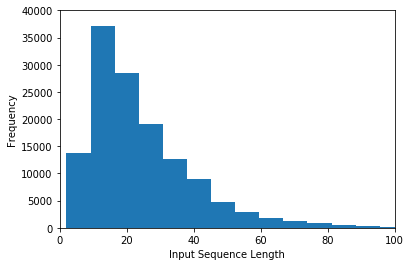

The total number of output is 133317
The total number of words in the output is 2580651
The average number of words in the output is 19.35725376358604
The maximum number of words in the output is 500


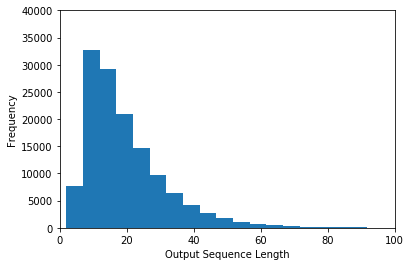

In [41]:
draw_train_diagram(train_pairs)

In [42]:
def short_sentences(pairs):
  """
  Hàm lọc ra các câu Anh - Việt trọn vẹn có độ dài từ 60 chữ trở xuống, dựa trên số liệu đã thống kê
  và giới hạn bộ nhớ của GPU dùng để huấn luyện
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    List các cặp câu Anh - Việt có độ dài từ 60 chữ trở xuống
  """
  
  result = []
  
  for i in range(len(pairs)):
    if len(pairs[i][0].split()) <= 60 and len(pairs[i][1].split()) <= 60:
      result.append([pairs[i][0], pairs[i][1]])
  
  return result

**Thống kê độ dài và số lượng câu trong tập các câu Anh - Việt có độ dài <= 60 chữ:**

In [43]:
short_train_pairs = short_sentences(train_pairs)

In [44]:
print_samples(short_train_pairs, 10)

<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> rachel pike the science behind a climate headline <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu và như thế này khi nói về chất lượng không khí hay khói bụi <end>
<start> headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog <end>
<start> cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển <end>
<start> they are both two branches of the same field of atmospheric science <end>
<start> các tiêu đề gần đây trông như thế này khi ban điều hành biến đổi khí hậu liên chính phủ gọi tắt là ipcc đưa ra bài nghiên c

In [45]:
def draw_short_train_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập các câu Anh - Việt có độ dài <= 60 chữ và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt có độ dài <= 60 chữ
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 15)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 40000])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 15)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 40000])
  plt.show()

The total number of input is 128111
The total number of words in the input is 2865245
The average number of words in the input is 22.365331626480163
The maximum number of words in the input is 60


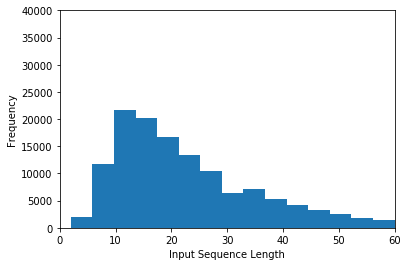

The total number of output is 128111
The total number of words in the output is 2273535
The average number of words in the output is 17.74660255559632
The maximum number of words in the output is 60


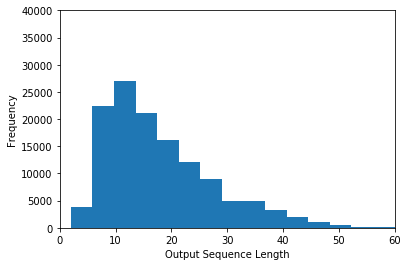

In [46]:
draw_short_train_diagram(short_train_pairs)

**Tạo tập Validation và chạy thử 10 câu Anh - Việt đầu tiên:**



In [47]:
val_pairs = create_dataset(validation_vi, validation_en)

In [48]:
print_samples(val_pairs, 10)

<start> làm sao tôi có thể trình bày trong 10 phút về sợi dây liên kết những người phụ nữ qua ba thế hệ về việc làm thế nào những sợi dây mạnh mẽ đáng kinh ngạc ấy đã níu chặt lấy cuộc sống của một cô bé bốn tuổi co quắp với đứa em gái nhỏ của cô bé với mẹ và bà trong suốt năm ngày đêm trên con thuyền nhỏ lênh đênh trên biển đông hơn 30 năm trước những sợi dây liên kết đã níu lấy cuộc đời cô bé ấy và không bao giờ rời đi cô bé ấy giờ sống ở san francisco và đang nói chuyện với các bạn hôm nay <end>
<start> how can i speak in 10 minutes about the bonds of women over three generations about how the astonishing strength of those bonds took hold in the life of a four year old girl huddled with her young sister her mother and her grandmother for five days and nights in a small boat in the china sea more than 30 years ago bonds that took hold in the life of that small girl and never let go that small girl now living in san francisco and speaking to you today <end>
<start> câu chuyện này chưa

**Thống kê độ dài và số lượng câu trong tập Validation:**

In [49]:
def draw_val_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập Validation Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 30)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 300])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 30)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 300])
  plt.show()

The total number of input is 1553
The total number of words in the input is 34631
The average number of words in the input is 22.2994204764971
The maximum number of words in the input is 119


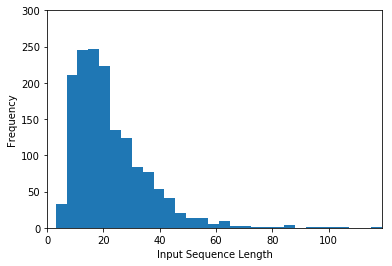

The total number of output is 1553
The total number of words in the output is 27276
The average number of words in the output is 17.56342562781713
The maximum number of words in the output is 92


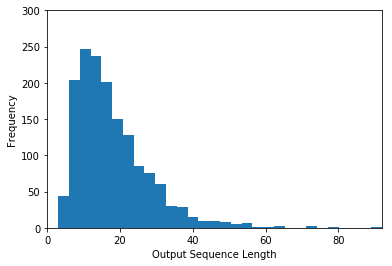

In [50]:
draw_val_diagram(val_pairs)

**Tạo tập Test và chạy thử 10 câu Anh - Việt đầu tiên:**


In [51]:
test_pairs = create_dataset(test_vi, test_en)

In [52]:
print_samples(test_pairs, 10)

<start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
<start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
<start> tôi đã rất tự hào về đất nước tôi <end>
<start> and i was very proud <end>
<start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
<start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
<start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào nhưng tôi vẫn nghĩ rằng mình sẽ sống cả cuộc đời ở bắctriều tiên cho tới khi tất cả mọi thứ đột nhiên thay đổi <end>
<start> although i often wondered a

**Thống kê độ dài và số lượng câu trong tập Test:**

In [53]:
def draw_test_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập Test Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 30)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 200])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 30)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 200])
  plt.show()

The total number of input is 1268
The total number of words in the input is 33169
The average number of words in the input is 26.15851735015773
The maximum number of words in the input is 120


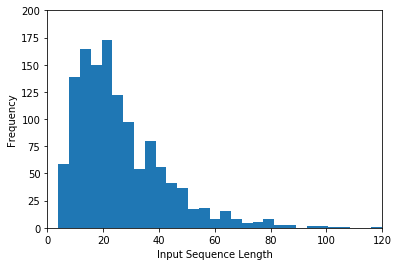

The total number of output is 1268
The total number of words in the output is 25523
The average number of words in the output is 20.128548895899055
The maximum number of words in the output is 95


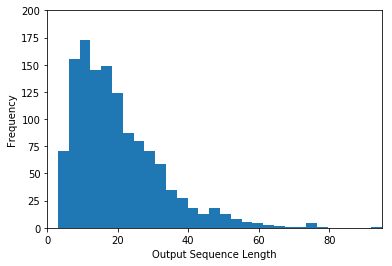

In [54]:
draw_test_diagram(test_pairs)

**Class LanguageIndex() chuyển từ chữ sang index và index sang chữ:**

In [55]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  """
  Cập nhật vocab từ các câu của ngôn ngữ cần khởi tạo
  Tạo mapping chữ -> số hiệu ("dad" -> 5) và số hiệu -> chữ (5 -> "dad")
  """
  
  def __init__(self, lang):
    """
    Hàm khởi tạo
    
    Tham số:
      lang: ngôn ngữ cần khởi tạo
      
    Returns:
      None
    """
    
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    """
    Cập nhật vocab từ các câu của ngôn ngữ cần khởi tạo
    Tạo mapping chữ -> số hiệu và số hiệu -> chữ
    """
    
    for phrase in self.lang:
      self.vocab.update(phrase.split())
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

**Hàm load_train_dataset() chuyển các chữ trong các câu Tiếng Anh & Tiếng Việt của tập Train sang dạng index:**

In [56]:
def max_length(tensor):
    """
    Trả về câu dài nhất trong tensor
    
    Tham số:
      tensor: tensor của các câu
    """
    
    return max(len(t) for t in tensor)

In [57]:
def load_train_dataset(input_path, target_path):
  """
  Nhập dữ liệu đầu vào cho tập Train
  Cập nhật vocab của từng ngôn ngữ Anh, Việt
  Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ (lựa chọn 60 chữ là dựa trên thống kê và giới hạn GPU)
  Tạo tensor chứa index của các cặp câu Anh - Việt trong tập Train
  Lấp đầy các câu ngắn bằng index 0
  
  Tham số:
    input_path: đường dẫn của tập câu Tiếng Việt
    target_path: đường dẫn của tập câu Tiếng Anh
    
  Returns:
    input_tensor: tensor index Tiếng Việt
    output_tensor: tensor index Tiếng Anh
    inp_lang: vocab Tiếng Việt
    targ_lang: vocab Tiếng Anh
    max_length_inp: độ dài lớn nhất trong tập câu Tiếng Việt
    max_length_tar: độ dài lớn nhất trong tập câu Tiếng Anh
    
  """
  
  # Nhập dữ liệu đầu vào cho tập Train
  pairs = create_dataset(input_path, target_path)
  
  # Cập nhật vocab của từng ngôn ngữ Anh, Việt
  inp_lang = LanguageIndex(vi for vi, en in pairs)
  targ_lang = LanguageIndex(en for vi, en in pairs)
  
  # Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ
  pairs = short_sentences(pairs)

  # Chuyển các từ trong câu Tiếng Việt sang index
  input_tensor = [[inp_lang.word2idx[word] for word in vi.split()] for vi, en in pairs]

  # Chuyển các từ trong câu Tiếng Anh sang index
  target_tensor = [[targ_lang.word2idx[word] for word in en.split()] for vi, en in pairs]

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

**Tạo train_dataset:**

In [58]:
input_tensor_train, target_tensor_train, inp_lang, targ_lang, max_length_inp, max_length_targ = load_train_dataset(train_vi, train_en)

In [155]:
input_tensor_train[0]

array([  966,  8810,  7882, 19586, 14950, 11495, 16976, 19606, 18357,
        8896,  7856,   965,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [157]:
# Hàm chuyển từ tensor về câu ban đầu
def tensor_to_sentence(tensor, lang):
    sentence = [lang.idx2word[idx] for idx in tensor.tolist()]
    return ' '.join(sentence)

# Ví dụ sử dụng
index = 0  # Chọn một mẫu trong tập dữ liệu
sample_input = input_tensor_train[index]
sample_output = target_tensor_train[index]

# Chuyển tensor về câu ban đầu sử dụng từ vựng của Tiếng Việt và Tiếng Anh
input_sentence = tensor_to_sentence(sample_input, inp_lang)
output_sentence = tensor_to_sentence(sample_output, targ_lang)

# In ra câu ban đầu và câu dịch tương ứng
print("Original Vietnamese Sentence:", input_sentence)
print("Original English Sentence:", output_sentence)


Original Vietnamese Sentence: <start> khoa học đằng sau một tiêu đề về khí hậu <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Original English Sentence: <start> rachel pike the science behind a climate headline <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [60]:
# In ra độ dài vocab của tập Tiếng Việt và Tiếng Anh
print(len(inp_lang.word2idx))
print(len(targ_lang.word2idx))

19823
42916


In [61]:
# In ra độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
max_length_inp, max_length_targ

(60, 60)

In [159]:
# In ra câu đầu tiên trong tensor Tiếng Việt
input_tensor_train[0]

array([  966,  8810,  7882, 19586, 14950, 11495, 16976, 19606, 18357,
        8896,  7856,   965,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [63]:
# In ra câu đầu tiên trong tensor Tiếng Anh
target_tensor_train[0]

array([  804, 30734, 28670, 38331, 33653,  4190,   806,  7530, 17534,
         803,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [64]:
def load_val_dataset(input_path, target_path, inp_lang, targ_lang):
  """
  Nhập dữ liệu đầu vào cho tập Validation
  Tạo tensor chứa index của các cặp câu Anh - Việt trong tập Validation dựa trên vocab của tập Train
  Lấp đầy các câu ngắn bằng index 0
  
  Tham số:
    input_path: đường dẫn của tập câu Tiếng Việt
    target_path: đường dẫn của tập câu Tiếng Anh
    inp_lang: vocab Tiếng Việt của tập Train
    targ_lang: vocab Tiếng Anh của tập Train
    
  Returns:
    input_tensor: tensor index Tiếng Việt của tập Validation
    output_tensor: tensor index Tiếng Anh của tập Validation
    inp_lang: vocab Tiếng Việt
    targ_lang: vocab Tiếng Anh
    max_length_inp: độ dài lớn nhất trong tập câu Tiếng Việt
    max_length_tar: độ dài lớn nhất trong tập câu Tiếng Anh
    
  """
  
  # Nhập dữ liệu đầu vào cho tập Validation
  pairs = create_dataset(input_path, target_path)
  
  # Chuyển các từ trong câu Tiếng Anh và Tiếng Việt sang index dựa trên vocab của tập Train
  # Từ nào không có trong vocab của tập Train thì cho index = 0
  
  input_tensor = []
  target_tensor = []
  
  for vi, en in pairs:
    inputs = []
    for word in vi.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)
    input_tensor.append(inputs)
    
    targets = []
    for word in en.split():
      try:
        index = targ_lang.word2idx[word]
      except:
        index = 0
      targets.append(index)
    target_tensor.append(targets)

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
  input_tensor = tf.convert_to_tensor(input_tensor)

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
  target_tensor = tf.convert_to_tensor(target_tensor)

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [65]:
input_tensor_val, target_tensor_val, inp_lang_val, targ_lang_val, max_length_inp_val, max_length_targ_val = load_val_dataset(validation_vi, validation_en, inp_lang, targ_lang)

In [66]:
# In ra độ dài lớn nhất trong các câu Tiếng Anh và Tiếng Việt của tập Validation
max_length_inp_val, max_length_targ_val

(119, 92)

In [67]:
input_tensor_val[0]

<tf.Tensor: id=5, shape=(119,), dtype=int32, numpy=
array([  966,  9937, 14910, 17635,  4380, 16837, 17285,  2833, 17219,
          32, 13409, 18357, 16181,  5159,  9691,  9309, 12266, 11922,
       13470, 12659, 13864,  1833, 16830,  7877, 18357, 18161,  9937,
       16830, 12497, 12266, 16181,  5159, 11412, 11450, 19440,  9039,
       11931, 19728, 19455, 12532,  3793, 10074,  4320, 16162,  4536,
       11495,  4387,  2859,  3029, 17527,  3971, 13981, 18389, 19674,
        5482,  6874, 12232,  4536,  4387,  2859, 18389, 11447, 18215,
        2827, 17219, 15979, 12553, 11872, 19467, 17280,  4067, 16672,
       12232,  9978, 19469, 17280,  2343, 19496,  7809,   553, 12553,
       17326, 12266, 16181,  5159,  9691,  9309, 19455, 12532, 10074,
        4320, 19660,  4387,  2859, 19728, 18215,  8910,  1955,  6550,
       14762, 19366,  4387,  2859, 19728,  6550, 16162, 19796, 14874,
        6025, 18215, 19352, 12537,  3630, 18389,  4345,  2936,  7788,
       11644,   965], dtype=int32)>

In [68]:
target_tensor_val[0]

<tf.Tensor: id=10, shape=(92,), dtype=int32, numpy=
array([  804, 18358,  6189, 18660, 35762, 19091,    31, 24476,   905,
       38331,  5082, 26613, 42297, 27196, 38514, 15939,   905, 18358,
       38331,  3071, 36696, 26613, 38488,  5082, 38880, 18080, 19091,
       38331, 22206, 26613,   806, 15230, 42618, 26690, 16198, 18402,
       42227, 17762, 42717, 34929, 17762, 25034,  2173, 17762, 16615,
       15047, 14686, 10010,  2173, 26035, 19091,   806, 35229,  4976,
       19091, 38331,  7149, 33805, 24949, 38312,   487, 42627,  1578,
        5082, 38322, 38880, 18080, 19091, 38331, 22206, 26613, 38322,
       35229, 16198,  2173, 25905, 22068, 16361, 38322, 35229, 16198,
       26319, 22432, 19091, 33298, 15300,  2173, 35765, 38776, 42713,
       38791,   803], dtype=int32)>

In [69]:
# Tổng kết số lượng cặp câu Anh-Việt của tập Train và tập Validation
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(128111, 128111, 1553, 1553)

# Chuẩn bị Train:

**Setup thông số:**

In [70]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

**Tạo các batch cho tập Train và tập Validation:**

In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

**Setup encoder và decoder:**

In [72]:
def gru(units):
  """
  Hàm setup gru dựa trên điều kiện có GPU hay không
  
  Tham số:
    units: số lượng hidden units
  """
  
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [73]:
class Encoder(tf.keras.Model):
    """
    Encoder cho Tiếng Việt
    """
  
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        """
        Hàm khởi tạo thông số cho encoder

        Tham số:
          vocab_size: kích cỡ vocab Tiếng Việt
          embedding_dim: kích cỡ word vector
          enc_units: số lượng hidden units
          batch_sz: kích cỡ 1 batch
        """
      
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        """
        Hàm chạy

        Returns:
          output, state: đầu ra của Encoder
        """
      
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        """
        Hàm khởi tạo hidden state
        """
        return tf.zeros((self.batch_sz, self.enc_units))

In [74]:
class BahdanauAttention(tf.keras.Model):
  """
  Bahdanau Attention cho seq2seq Anh - Việt
  """
  
  def __init__(self, units):
    """
    Khởi tạo Attention
    
    Tham số:
      units: số lượng hiddden units của decoder
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [75]:
class Decoder(tf.keras.Model):
    """
    Decoder cho Tiếng Anh
    """
  
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
      """
      Hàm khởi tạo thông số cho decoder
      
      Tham số:
        vocab_size: kích cỡ vocab Tiếng Anh
        embedding_dim: kích cỡ word vector
        dec_units: số lượng hidden units
        batch_sz: kích cỡ 1 batch
      """
      
      super(Decoder, self).__init__()
      self.batch_sz = batch_sz
      self.dec_units = dec_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = gru(self.dec_units)
      self.fc = tf.keras.layers.Dense(vocab_size)

      # used for attention
      self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the GRU
      output, state = self.gru(x)

      # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

      # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, attention_weights
        
    def initialize_hidden_state(self):
        """
        Hàm khởi tạo hidden state
        """
        return tf.zeros((self.batch_sz, self.dec_units))

In [76]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

**Setup optimizer và checkpoint:**

In [77]:
LEARNING_RATE = 0.001

In [78]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [79]:
def loss_function(real, pred):
  """
  Hàm tính loss giữa prediction và target
  """
  
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  
  return tf.reduce_mean(loss_)

In [80]:
global_step = tf.train.get_or_create_global_step()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Setup hàm huấn luyện tập Train:**

In [81]:
from fastprogress import master_bar, progress_bar

In [82]:
def epoch_training(encoder, decoder, dataset, global_step, mb, num_step):
    """
    Hàm huấn luyện trên tập Train

    Tham số:
      encoder: encoder Tiếng Việt
      decoder: decoder Tiếng Anh
      dataset: train datset
      global_step, mb, num_step: thông số vẽ đồ thị mô hình

    Returns:
      loss trung bình của 1 epoch
    """
  
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        with tf.GradientTape() as tape:
            # Feedforward
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
                
            batch_loss = (loss / int(targ.shape[1]))
            
            train_losses.append(batch_loss)
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables), global_step=global_step) 
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    return sum(train_losses)/ len(train_losses)

**Setup hàm đánh giá tập Validation:**

In [83]:
def epoch_evaluation(encoder, decoder, dataset, mb, num_step):
    """
    Hàm đánh giá trên tập Validation

    Tham số:
      encoder: encoder Tiếng Việt
      decoder: decoder Tiếng Anh
      dataset: validation datset
      global_step, mb, num_step: thông số vẽ đồ thị mô hình

    Returns:
      loss trung bình của 1 epoch
    """
  
    val_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        # Feed forward
        enc_output, enc_hidden = encoder(inp, hidden)
            
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
        batch_loss = (loss / int(targ.shape[1]))
        
        val_losses.append(batch_loss)
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    
    return sum(val_losses)/ len(val_losses)

# Train

Instructions for updating:
Colocations handled automatically by placer.


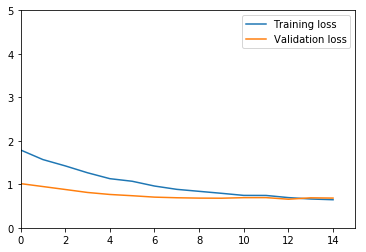

Finish train epoch 0 with loss 1.7896
Finish validate epoch 0 with loss 1.0162
Finish train epoch 1 with loss 1.5690
Finish validate epoch 1 with loss 0.9487
Finish train epoch 2 with loss 1.4238
Finish validate epoch 2 with loss 0.8810
Finish train epoch 3 with loss 1.2653
Finish validate epoch 3 with loss 0.8124
Finish train epoch 4 with loss 1.1297
Finish validate epoch 4 with loss 0.7665
Finish train epoch 5 with loss 1.0703
Finish validate epoch 5 with loss 0.7378
Finish train epoch 6 with loss 0.9604
Finish validate epoch 6 with loss 0.7051
Finish train epoch 7 with loss 0.8841
Finish validate epoch 7 with loss 0.6908
Finish train epoch 8 with loss 0.8385
Finish validate epoch 8 with loss 0.6826
Finish train epoch 9 with loss 0.7932
Finish validate epoch 9 with loss 0.6803
Finish train epoch 10 with loss 0.7450
Finish validate epoch 10 with loss 0.6930
Finish train epoch 11 with loss 0.7438
Finish validate epoch 11 with loss 0.6939
Finish train epoch 12 with loss 0.6943
Finish va

In [84]:
EPOCHS = 15

mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss']
training_losses = []
validation_losses = []
x = []

train_step = math.floor(len(input_tensor_train)*1.0/BATCH_SIZE)
val_step = math.floor(len(input_tensor_val)*1.0/BATCH_SIZE)

for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = encoder.initialize_hidden_state()
    x.append(epoch)
    
    ### START CODE HERE
    # Training
    training_loss = epoch_training(encoder, decoder, train_dataset, global_step, mb, train_step)
    
    # Cập nhật thông tin sau khi huấn luyện
    training_losses.append(training_loss)
    
    # Validating
    valid_loss = epoch_evaluation(encoder, decoder, validation_dataset, mb, val_step)
    
    # Cập nhật thông tin sau khi validate
    validation_losses.append(valid_loss)
    
    # Cập nhật đồ thị
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses]], [0,EPOCHS], [0,5])
    
    print('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    print('Finish validate epoch {} with loss {:.4f}'.format(epoch,valid_loss))
    
    # Update score và lưu model có score tốt nhất
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    ### END CODE HERE
    

In [85]:
# khôi phục checkpoint cuối cùng trong folder checkdir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Đánh giá output

In [86]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    """
    Hàm dịch từng câu và tạo thông số ma trận tương quan attention giữa câu Tiếng Anh và câu Tiếng Việt

    Tham số:
      sentence: câu Tiếng Việt
      encoder: encoder Tiếng Việt
      decoder: decoder Tiếng Anh
      inp_lang: vocab Tiếng Việt
      targ_lang: vocab Tiếng Anh
      max_length_inp: độ dài lớn nhất câu Tiếng Việt
      max_length_targ: độ dài lớn nhất câu Tiếng Anh

    Returns:
      result: câu Tiếng Anh đã dịch
      sentence: câu Tiếng Việt đưa vào
      attention_plot: thống số để vẽ ma trận Attention
    """
  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    # Làm sạch câu Tiếng Anh
    sentence = preprocess_sentence(sentence)
    
    # Chuyển câu Tiếng Anh sang index
    inputs = []
    for word in sentence.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    # Dịch
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id]

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        else:
          result += ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [104]:
# # function for plotting the attention weights
# def plot_attention(attention, sentence, predicted_sentence):
#     """
#     Hàm vẽ ma trận Attention

#     Tham số:
#       attention: thông số ma trận
#       sentence: câu Tiếng Anh
#       predicted_sentence: câu Tiếng Anh đã dịch

#     Returns:
#       None
#     """
  
#     fig = plt.figure(figsize=(5,5))
#     ax = fig.add_subplot(1, 1, 1)
# #     ax.matshow(attention, cmap='viridis')
    
#     fontdict = {'fontsize': 14}
    
#     ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
#     ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

# #     plt.show()

In [150]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    """
    Hàm dịch và vẽ ma trận attention

    Tham số:
      sentence: câu Tiếng Việt
      encoder: encoder Tiếng Việt
      decoder: decoder Tiếng Anh
      inp_lang: vocab Tiếng Việt
      targ_lang: vocab Tiếng Anh
      max_length_inp: độ dài lớn nhất câu Tiếng Việt
      max_length_targ: độ dài lớn nhất câu Tiếng Anh

    Returns:
      None
    """
  
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
#     attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
#     plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Dịch tập Test

In [ ]:
translate(u'chào mừng bạn', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

In [128]:
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Python implementation of BLEU and smooth-BLEU.

This module provides a Python implementation of BLEU and smooth-BLEU.
Smooth BLEU is computed following the method outlined in the paper:
Chin-Yew Lin, Franz Josef Och. ORANGE: a method for evaluating automatic
evaluation metrics for machine translation. COLING 2004.
"""

import collections
import math


def _get_ngrams(segment, max_order):
  """Extracts all n-grams upto a given maximum order from an input segment.

  Args:
    segment: text segment from which n-grams will be extracted.
    max_order: maximum length in tokens of the n-grams returned by this
        methods.

  Returns:
    The Counter containing all n-grams upto max_order in segment
    with a count of how many times each n-gram occurred.
  """
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  """Computes BLEU score of translated segments against one or more references.

  Args:
    reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
    translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.

  Returns:
    3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
    precisions and brevity penalty.
  """
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)

**Tạo tập Test:**

In [129]:
pairs_2 = create_dataset(test_vi, test_en)

**Dịch, tính bleu score và vẽ ma trận attention trên tập Test:**

In [161]:
translation_result = []
for i in range(len(pairs_2)):
  vi_sentence = pairs_2[i][0].strip("<start>").strip("<end>").strip()
  en_result, vi_sentence, attention_plot = evaluate(vi_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
  en_result = '<start> ' + en_result.strip()
  en_groundtruth = pairs_2[i][1]
  bleu_score = compute_bleu([[en_groundtruth.split()]], [en_result.split()], max_order=1)[0]*100
#   print('\nInput: ', vi_sentence)
#   print('Groundtruth: ', en_groundtruth)
#   print('Translation: ', en_result)
#   print('Bleu Score: ', bleu_score)
#   if len(en_result.split(' ')) <= 10:
#     attention_plot = attention_plot[:len(en_result.split(' ')), :len(vi_sentence.split(' '))]
#     plot_attention(attention_plot, vi_sentence.split(' '), en_result.strip('<start> ').split(' '))
  translation_result.append([vi_sentence, en_groundtruth, en_result, bleu_score, attention_plot])

**Tính bleu score trung bình trên tập Test:**

In [167]:
bleu_score_list = []
for i in range(len(translation_result)):
  bleu_score_list.append(translation_result[i][3])

mean_bleu_score = sum(bleu_score_list)/len(bleu_score_list)
print("Average Bleu Score: ", mean_bleu_score)

Average Bleu Score:  43.18668785739128
